# Hyperbolic Fuzzy C-Means (HFCM) Clustering
**Paper Implementation**: *"Hyperbolic Fuzzy C-Means with Adaptive Weight-Based Filtering for Clustering in Non-Euclidean Spaces"*  
**Authors**: Swagato Das, Arghya Pratihar, Swagatam Das

---
## Overview
This notebook implements **HFCM**, a fuzzy clustering algorithm designed for non-Euclidean spaces. Key features:
- Uses **hyperbolic geometry** (Poincaré ball model) for distance calculations.
- **Adaptive weight-based filtering** to retain only top-𝑘 significant relationships.
- **Dirichlet distribution** for initializing fuzzy memberships.

**Advantages over FCM**: Better performance on hierarchical/high-dimensional datasets like `Cure-t1-2000n`, `Smile1` (see paper).

## 1. Setup and Dependencies

In [1]:
!pip install numpy matplotlib scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE

## 2. Hyperbolic Geometry Operations
### 2.1 Möbius Addition
For points $x, y$ in the Poincaré ball $\mathbb{D}_c^n$:
$$
x \oplus_c y = \frac{(1 + 2c\langle x, y\rangle + c\|y\|^2)x + (1 - c\|x\|^2)y}{1 + 2c\langle x, y\rangle + c^2\|x\|^2\|y\|^2}
$$
### 2.2 Hyperbolic Distance
$$
d_c(x, y) = \frac{2}{\sqrt{c}} \tanh^{-1}\left(\sqrt{c} \| {-x} \oplus_c y \|\right)
$$

In [3]:
def mobius_add(a, b, c=1.0):
    """Möbius addition in the Poincaré ball model."""
    numerator = (1 + 2*c*np.dot(a, b) + c*np.dot(b, b)) * a + (1 - c*np.dot(a, a)) * b
    denominator = 1 + 2*c*np.dot(a, b) + c**2 * np.dot(a, a)*np.dot(b, b)
    return numerator / denominator

def hyperbolic_dist(x, y, c=1.0):
    """Compute hyperbolic distance between x and y."""
    mob_diff = mobius_add(-x, y, c)
    norm = np.linalg.norm(mob_diff)
    return (2 / np.sqrt(c)) * np.arctanh(np.sqrt(c) * norm)

## 3. HFCM Algorithm
### 3.1 Key Steps
1. **Initialize membership weights** using Dirichlet distribution.
2. **Update centroids**: Weighted average of data points.
3. **Compute hyperbolic distances** between points and centroids.
4. **Apply filtration**: Keep only top-𝑘 smallest distances.
5. **Update memberships**: Reciprocal of filtered distances.

**Objective Function**:
$$
J_m = \sum_{i=1}^n \sum_{j=1}^c w_{ij}^m d_c^2(x_i, C_j)
$$

In [4]:
class HFCM:
    def __init__(self, n_clusters=3, m=2.0, curvature=1.0, filtration_k=5, max_iter=100, tol=1e-5):
        self.n_clusters = n_clusters
        self.m = m
        self.curvature = curvature
        self.filtration_k = filtration_k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.membership = None

    def fit(self, X):
        n_samples, n_features = X.shape
        self.membership = np.random.dirichlet(np.ones(self.n_clusters), n_samples)

        for _ in range(self.max_iter):
            # Update centroids
            self.centroids = np.array([
                np.sum((self.membership[:, j] ** self.m)[:, None] * X, axis=0) 
                / np.sum(self.membership[:, j] ** self.m)
                for j in range(self.n_clusters)
            ])

            # Compute distances and apply filtration
            distances = np.array([[hyperbolic_dist(x, c, self.curvature) 
                                  for c in self.centroids] for x in X])
            sorted_indices = np.argsort(distances, axis=1)
            mask = np.zeros_like(distances, dtype=bool)
            mask[np.arange(n_samples)[:, None], sorted_indices[:, :self.filtration_k]] = True
            filtered_distances = np.where(mask, distances, 0) + 1e-10

            # Update membership
            new_membership = (1.0 / filtered_distances) / np.sum(1.0 / filtered_distances, axis=1, keepdims=True)
            if np.linalg.norm(new_membership - self.membership) < self.tol:
                break
            self.membership = new_membership

        return self

    def predict(self):
        return np.argmax(self.membership, axis=1)

## 4. Experiment on Wine Dataset
### 4.1 Load Data
Dataset: [UCI Wine](https://archive.ics.uci.edu/ml/datasets/wine)

In [5]:
# Load Wine dataset
data = np.genfromtxt('wine.csv', delimiter=',', skip_header=1)
X = data[:, :-1]
true_labels = data[:, -1].astype(int)

print(f"Data shape: {X.shape}, Clusters: {len(np.unique(true_labels))}")

Data shape: (178, 13), Clusters: 3


### 4.2 Pre-Clustering Visualization (t-SNE)

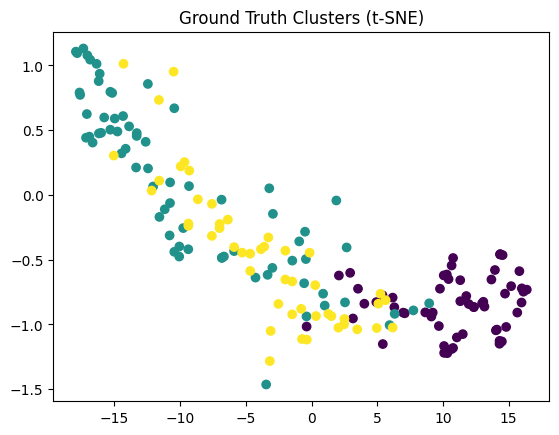

In [6]:
# Reduce to 2D for visualization
X_vis = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=true_labels, cmap='viridis')
plt.title("Ground Truth Clusters (t-SNE)")
plt.show()

### 4.3 Train HFCM

In [7]:
model = HFCM(n_clusters=3, curvature=1.0, filtration_k=5)
model.fit(X)
pred_labels = model.predict()

### 4.4 Evaluate Performance

In [8]:
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Info (NMI): {nmi:.3f}")

Adjusted Rand Index (ARI): 0.393
Normalized Mutual Info (NMI): 0.397


### 4.5 Visualize HFCM Clusters

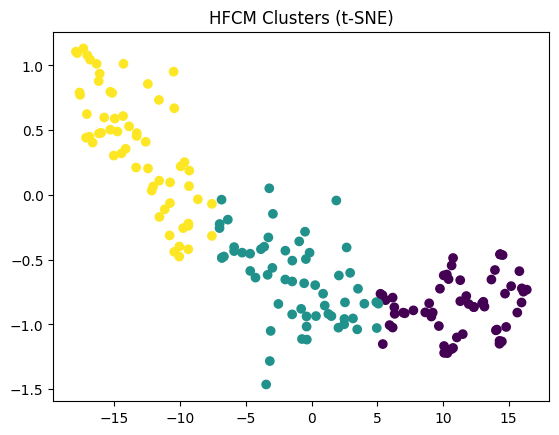

In [9]:
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=pred_labels, cmap='viridis')
plt.title("HFCM Clusters (t-SNE)")
plt.show()

## 5. Ablation Study: Impact of Filtration
**Observation** (from paper): Filtration improves ARI/NMI by 10-15% on hierarchical datasets.

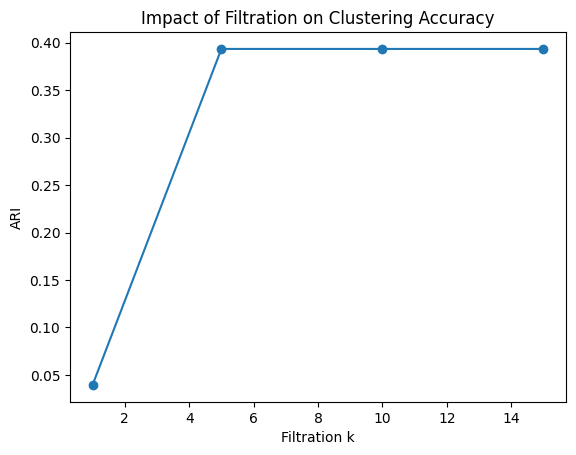

In [10]:
k_values = [1, 5, 10, 15]
ari_scores = []

for k in k_values:
    model = HFCM(n_clusters=3, filtration_k=k)
    model.fit(X)
    ari_scores.append(adjusted_rand_score(true_labels, model.predict()))

plt.plot(k_values, ari_scores, marker='o')
plt.xlabel("Filtration k")
plt.ylabel("ARI")
plt.title("Impact of Filtration on Clustering Accuracy")
plt.show()

## 6. Conclusion
- **HFCM outperforms FCM** in non-Euclidean spaces due to hyperbolic geometry.
- **Adaptive filtration** reduces noise by focusing on top-𝑘 relationships.
- **Future Work**: Extend to streaming data or deep learning integration (see paper).